1. Import packages.

In [2]:
# import packages
import numpy as np
import pandas as pd
import requests
import time
import re
import math
from decimal import Decimal

2. Read community data set obtained from Anjuke website, and clean the data set.

In [165]:
# read data
data = pd.read_csv('上海市安居客202305.csv')

# select all houses in Shanghai
data_sh = data[data['区县'] != '上海周边']
data_sh.reset_index(drop = True, inplace = True)

# select all communities for living
data_sh = data_sh[(data_sh['物业类型'] == '公寓住宅') | (data_sh['物业类型'] == '别墅') | (data_sh['物业类型'] == '暂无') | (data_sh['物业类型'] == '商住楼') |
                  (data_sh['物业类型'] == '其他')]
data_sh = data_sh[(data_sh['权属类别'] != '办公') & (data_sh['权属类别'] != '商业') & (data_sh['权属类别'] != '工业') & (data_sh['权属类别'] != '办公|商业') &
                  (data_sh['权属类别'] != '军产房')]
# data_sh.reset_index(drop = True, inplace = True)
# data_sh.info()

# check the duplicate rows
duplicate = data_sh[data_sh.duplicated(['链接','小区名字'])] # there are lots of duplicate rows with same url and community name (1865)
duplicate

# delete all duplicate rows
data_sh_1 = data_sh.drop_duplicates(subset=['链接','小区名字'], keep='first')
data_sh_1.reset_index(drop = True, inplace = True)
data_sh_1

# clean the data set, deal with the null, nan, and unknown values in the dataframe, and change to numeric type
#completion of year ('竣工时间')：
for i in range (len(data_sh_1)): # delete '年'
    if len(data_sh_1['竣工时间'][i]) > 4:
        data_sh_1['竣工时间'][i] = data_sh_1['竣工时间'][i].replace('年', '')
    else:
        data_sh_1['竣工时间'][i] = data_sh_1['竣工时间'][i] # is the value is '暂无'(unknown), temporaryly keep the value of '暂无'
        
data_sh_1['built_year_last'] = ''
for i in range (len(data_sh_1)): # get the latest year, if there are more than one completion year
    if len(data_sh_1['竣工时间'][i]) > 8:
        data_sh_1['built_year_last'][i] = data_sh_1['竣工时间'][i].split('、')[-1]
    else:
        data_sh_1['built_year_last'][i] = data_sh_1['竣工时间'][i]

# deal with the 'unknown'
unknown = data_sh_1[data_sh_1['built_year_last'] == '暂无'] 
unknown_zjf = unknown[unknown['小区名字'].str.contains('自建房')]
unknown_zjf_index = list(unknown_zjf.index.values) # get the index for all self-built communities which also with unknown built year
unknown_zjf_index
for i in unknown_zjf_index:
    data_sh_1.loc[i, 'built_year_last'] = '2001'
    # set the built_year of this part of self-built community or house into '2001',
    # since most of them were built earlier than 2014, if the value is smaller than 2014 is acceptable
# data_sh_1.to_csv('data_sh_1_for_unknown_built_year_last.csv') # export the current data set to full the rest unknown built year manually
# read the data_sh_1 dataset back
data_sh_1 = pd.read_csv("data_sh_1_for_unknown_built_year_last.csv", encoding = 'gbk')
data_sh_1 = data_sh_1[(data_sh_1['权属类别'] != '办公') | (data_sh_1['权属类别'] != '商业') | (data_sh_1['权属类别'] != '工业') | (data_sh_1['权属类别'] != '办公|商业') |
                  (data_sh_1['权属类别'] != '军产房')]
## since most of the rest communities with unknown built year were built earlier than 1990, and it is hardly to find public evidence about when they built, I set them into 1990
data_sh_1.loc[data_sh_1['built_year_last'] == '暂无', 'built_year_last'] = '1990'
# change the data type of built_year_last to int
data_sh_1['built_year_last'] = data_sh_1['built_year_last'].astype(int)

# select useful columns (variables):
data_sh_2 = data_sh_1.drop(['链接', '所属商圈', '物业公司', '在售房源', '在租房源', '开发商', '纬度', '经度'], axis = 1)
# rename the column names:
data_sh_2 = data_sh_2.rename(columns = {'小区名字':'community_name', '城市': 'city', '区县':'district', '商圈':'commercial_district',
                                 '价格':'price','竣工时间':'built_year','小区地址':'address','物业类型':'property_type','权属类别':'ownership_category',
                                 '产权年限': 'property_right_period', '总户数': 'total_house_num', '总建面积': 'total_cons_area', '容积率': 'volume ratio',
                                 '绿化率': 'green_rate', '建筑类型': 'building_type', '统一供暖': 'heating', '供水供电': 'water_power', '停车位': 'parking',
                                 '物业费': 'property_costs', '停车费': 'parking_fee', '车位管理费': 'parking_management_fee'})

,链接,小区名字,城市,区县,商圈,价格,纬度,经度,物业类型,权属类别,...,供水供电,停车位,物业费,停车费,车位管理费,物业公司,小区地址,开发商,在售房源,在租房源
243,https://shanghai.anjuke.com/community/view/764...,高桥红坊,上海市市辖区,浦东,高桥,36806元/㎡,31.353200,121.580957,商住楼,商业,...,商用,50(1:0.3),8.00元/平米/月,地面100.00元/月,暂无,上海伟发物业有限公司,张杨北路5688弄,上海金联置业有限公司,NaN,NaN
301,https://shanghai.anjuke.com/community/view/729...,悦天地,上海市市辖区,浦东,曹路,28605元/㎡,31.278464,121.679624,商住楼,商业,...,商用,150(1:0.4),5.80元/平米/月,地面150.00元/月,暂无,上海倚江物业管理有限公司,"川沙路777弄,川沙路795弄",上海浦发振丰房地产发展有限公司,NaN,NaN
619,https://shanghai.anjuke.com/community/view/817...,海上国际花园(二期),上海市市辖区,浦东,北蔡,45005元/㎡,31.186993,121.555476,商住楼,商业,...,商用,134(1:0.6),2.10元/平米/月,地面300.00元/月,暂无,上海杨房物业管理有限公司,博华路380弄,上海香溢房地产有限公司,NaN,NaN
636,https://shanghai.anjuke.com/community/view/108...,中环森兰国际,上海市市辖区,浦东,高行,23666元/㎡,31.321527,121.594989,商住楼,商业,...,商用,暂无,3.00元/平米/月,地面150.00元/月,暂无,业主自管,洲海路999号,单位自建,NaN,NaN
639,https://shanghai.anjuke.com/community/view/104...,森兰自由度,上海市市辖区,浦东,高行,39361元/㎡,31.318694,121.594032,商住楼,商业,...,商用,暂无,5.80元/平米/月,地面150.00元/月,暂无,上海华高物业有限公司,启帆路871弄,上海朋越投资有限公司,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24982,https://shanghai.anjuke.com/community/view/119...,新金山广场,上海市市辖区,金山,石化,11694元/㎡,30.730184,121.340433,商住楼,商业,...,商用,暂无,0.50元/平米/月,地面150.00元/月,暂无,业主自管,龙胜路718号,单位自建,NaN,NaN
24999,https://shanghai.anjuke.com/community/view/104...,乐禧汇,上海市市辖区,金山,石化,14444元/㎡,30.737233,121.371790,商住楼,商业,...,商用,269(1:0.5),15.00元/平米/月,地面150.00元/月,暂无,业主自管,同凯路40弄,单位自建,NaN,NaN
25090,https://shanghai.anjuke.com/community/view/119...,金上海生活广场,上海市市辖区,金山,朱泾,9466元/㎡,30.892190,121.174532,商住楼,商业,...,商用,暂无,3.80元/平米/月,地面150.00元/月,暂无,上海建廷物业管理有限公司,金龙新街558号,上海市博辉房地产开发有限公司,NaN,NaN
25115,https://shanghai.anjuke.com/community/view/729...,祥腾东平森林1号,上海市市辖区,崇明,堡镇,14743元/㎡,31.682329,121.479267,商住楼,商业,...,商用,暂无,3.00元/平米/月,地面150.00元/月,暂无,上海遥瞻物业管理有限公司,北沿公路2151弄,上海祥明房地产发展有限公司,NaN,NaN


3. Scraping coordinates of each community from Baidu Map API. Since there is a limitation for geocoding for each time, I split the data set into 10 subsets.

In [10]:
# scraping coordinates from Baidu Map API
def is_json(myjson):
    try:
        json_object = json.loads(myjson)
    except:
        return False
    return True

def geocodeB(address):
    base_url = "http://api.map.baidu.com/geocoder?address={address}&output=json&ret_coordtype=bd09ll&key=PGo9SrvKurMpWxmgI5fq7S2Z5MoAmofR".format(address=address)
    response = requests.get(base_url)
    time.sleep(2)
    try:
        answer = response.json()
        latitude = answer['result']['location']['lng']
        longitude = answer['result']['location']['lat']
        return str(latitude) + "," + str(longitude)
    except:
        return ""
    
# start to scrape coordinates of each community from Baidu Map API
data_sh_2['address_1'] = '上海市' + data_sh_2['address']
data_sh_2['coordinates'] = ''

In [37]:
# get coordinates of all communities in Shanghai based on the Anjuke data set
group1 = data_sh_2.iloc[:399,:]
for idx,row in group1.iterrows():
    if len(str(group1.loc[idx,"address_1"])) > 0: 
        group1.loc[idx,"coordinates"] = geocodeB(group1.loc[idx,"address_1"])
        # print(idx, group1.loc[idx,"community_name"], group1.loc[idx,"address_1"], group1.loc[idx,"coordinates"])
        #if idx > 20:
        #    break

if len(group1['coordinates']) > 1:
    group1['longitude'], group1['latitude'] = group1['coordinates'].str.split(',', 1).str
else:
    group1['longitude'], group1['latitude'] = ''
group1.to_csv('group1.csv')


C:\Users\zhaol\AppData\Local\Temp\ipykernel_23408\2769620725.py:11: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  group1['longitude'], group1['latitude'] = group1['coordinates'].str.split(',', 1).str
C:\Users\zhaol\AppData\Local\Temp\ipykernel_23408\2769620725.py:11: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  group1['longitude'], group1['latitude'] = group1['coordinates'].str.split(',', 1).str
C:\Users\zhaol\AppData\Local\Temp\ipykernel_23408\2769620725.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group1['longitude'], group1['latitude'] = group1['coordinates'].str.split(',', 1).str
C:\Users\zhaol\AppDat

In [38]:
group2 = data_sh_2.iloc[399:1000,:]
for idx,row in group2.iterrows():
    if len(str(group2.loc[idx,"address_1"])) > 0: 
        group2.loc[idx,"coordinates"] = geocodeB(group2.loc[idx,"address_1"])
        # print(idx, group2.loc[idx,"community_name"], group2.loc[idx,"address_1"], group2.loc[idx,"coordinates"])
        #if idx > 20:
        #    break

if len(group2['coordinates']) > 1:
    group2['longitude'], group2['latitude'] = group2['coordinates'].str.split(',', 1).str
else:
    group2['longitude'], group2['latitude'] = ''
group2.to_csv('group2.csv')

C:\Users\zhaol\AppData\Local\Temp\ipykernel_23408\3534442367.py:10: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  group2['longitude'], group2['latitude'] = group2['coordinates'].str.split(',', 1).str
C:\Users\zhaol\AppData\Local\Temp\ipykernel_23408\3534442367.py:10: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  group2['longitude'], group2['latitude'] = group2['coordinates'].str.split(',', 1).str
C:\Users\zhaol\AppData\Local\Temp\ipykernel_23408\3534442367.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group2['longitude'], group2['latitude'] = group2['coordinates'].str.split(',', 1).str
C:\Users\zhaol\AppDat

In [12]:
group3 = data_sh_2.iloc[1000:3000,:]
for idx,row in group3.iterrows():
    if len(str(group3.loc[idx,"address_1"])) > 0: 
        group3.loc[idx,"coordinates"] = geocodeB(group3.loc[idx,"address_1"])
        # print(idx, group3.loc[idx,"community_name"], group3.loc[idx,"address_1"], group3.loc[idx,"coordinates"])

if len(group3['coordinates']) > 1:
    group3['longitude'], group3['latitude'] = group3['coordinates'].str.split(',', 1).str
else:
    group3['longitude'], group3['latitude'] = ''
group3.to_csv('group3.csv')

C:\Users\zhaol\AppData\Local\Temp\ipykernel_23368\1281693569.py:8: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  group3['longitude'], group3['latitude'] = group3['coordinates'].str.split(',', 1).str
C:\Users\zhaol\AppData\Local\Temp\ipykernel_23368\1281693569.py:8: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  group3['longitude'], group3['latitude'] = group3['coordinates'].str.split(',', 1).str
C:\Users\zhaol\AppData\Local\Temp\ipykernel_23368\1281693569.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group3['longitude'], group3['latitude'] = group3['coordinates'].str.split(',', 1).str
C:\Users\zhaol\AppData\L

In [13]:
group4 = data_sh_2.iloc[3000:6000,:]
for idx,row in group4.iterrows():
    if len(str(group4.loc[idx,"address_1"])) > 0: 
        group4.loc[idx,"coordinates"] = geocodeB(group4.loc[idx,"address_1"])
        # print(idx, group4.loc[idx,"community_name"], group4.loc[idx,"address_1"], group4.loc[idx,"coordinates"])

if len(group4['coordinates']) > 1:
    group4['longitude'], group4['latitude'] = group4['coordinates'].str.split(',', 1).str
else:
    group4['longitude'], group4['latitude'] = ''
group4.to_csv('group4.csv')

C:\Users\zhaol\AppData\Local\Temp\ipykernel_23368\864591177.py:8: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  group4['longitude'], group4['latitude'] = group4['coordinates'].str.split(',', 1).str
C:\Users\zhaol\AppData\Local\Temp\ipykernel_23368\864591177.py:8: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  group4['longitude'], group4['latitude'] = group4['coordinates'].str.split(',', 1).str
C:\Users\zhaol\AppData\Local\Temp\ipykernel_23368\864591177.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group4['longitude'], group4['latitude'] = group4['coordinates'].str.split(',', 1).str
C:\Users\zhaol\AppData\Loca

In [14]:
group5 = data_sh_2.iloc[6000:9000,:]
for idx,row in group5.iterrows():
    if len(str(group5.loc[idx,"address_1"])) > 0: 
        group5.loc[idx,"coordinates"] = geocodeB(group5.loc[idx,"address_1"])
        # print(idx, group5.loc[idx,"community_name"], group5.loc[idx,"address_1"], group5.loc[idx,"coordinates"])

if len(group5['coordinates']) > 1:
    group5['longitude'], group5['latitude'] = group5['coordinates'].str.split(',', 1).str
else:
    group5['longitude'], group5['latitude'] = ''
group5.to_csv('group5.csv')

C:\Users\zhaol\AppData\Local\Temp\ipykernel_23368\1075986220.py:8: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  group5['longitude'], group5['latitude'] = group5['coordinates'].str.split(',', 1).str
C:\Users\zhaol\AppData\Local\Temp\ipykernel_23368\1075986220.py:8: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  group5['longitude'], group5['latitude'] = group5['coordinates'].str.split(',', 1).str
C:\Users\zhaol\AppData\Local\Temp\ipykernel_23368\1075986220.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group5['longitude'], group5['latitude'] = group5['coordinates'].str.split(',', 1).str
C:\Users\zhaol\AppData\L

In [15]:
group6 = data_sh_2.iloc[9000:12000,:]
for idx,row in group6.iterrows():
    if len(str(group6.loc[idx,"address_1"])) > 0: 
        group6.loc[idx,"coordinates"] = geocodeB(group6.loc[idx,"address_1"])
        # print(idx, group6.loc[idx,"community_name"], group6.loc[idx,"address_1"], group6.loc[idx,"coordinates"])

if len(group6['coordinates']) > 1:
    group6['longitude'], group6['latitude'] = group6['coordinates'].str.split(',', 1).str
else:
    group6['longitude'], group6['latitude'] = ''
group6.to_csv('group6.csv')

C:\Users\zhaol\AppData\Local\Temp\ipykernel_23368\2214267960.py:8: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  group6['longitude'], group6['latitude'] = group6['coordinates'].str.split(',', 1).str
C:\Users\zhaol\AppData\Local\Temp\ipykernel_23368\2214267960.py:8: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  group6['longitude'], group6['latitude'] = group6['coordinates'].str.split(',', 1).str
C:\Users\zhaol\AppData\Local\Temp\ipykernel_23368\2214267960.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group6['longitude'], group6['latitude'] = group6['coordinates'].str.split(',', 1).str
C:\Users\zhaol\AppData\L

In [16]:
group7 = data_sh_2.iloc[12000:15000,:]
for idx,row in group7.iterrows():
    if len(str(group7.loc[idx,"address_1"])) > 0: 
        group7.loc[idx,"coordinates"] = geocodeB(group7.loc[idx,"address_1"])
        # print(idx, group7.loc[idx,"community_name"], group7.loc[idx,"address_1"], group7.loc[idx,"coordinates"])

if len(group7['coordinates']) > 1:
    group7['longitude'], group7['latitude'] = group7['coordinates'].str.split(',', 1).str
else:
    group7['longitude'], group7['latitude'] = ''
group7.to_csv('group7.csv')

C:\Users\zhaol\AppData\Local\Temp\ipykernel_23368\732830333.py:8: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  group7['longitude'], group7['latitude'] = group7['coordinates'].str.split(',', 1).str
C:\Users\zhaol\AppData\Local\Temp\ipykernel_23368\732830333.py:8: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  group7['longitude'], group7['latitude'] = group7['coordinates'].str.split(',', 1).str
C:\Users\zhaol\AppData\Local\Temp\ipykernel_23368\732830333.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group7['longitude'], group7['latitude'] = group7['coordinates'].str.split(',', 1).str
C:\Users\zhaol\AppData\Loca

In [17]:
group8 = data_sh_2.iloc[15000:18000,:]
for idx,row in group8.iterrows():
    if len(str(group8.loc[idx,"address_1"])) > 0: 
        group8.loc[idx,"coordinates"] = geocodeB(group8.loc[idx,"address_1"])
        # print(idx, group8.loc[idx,"community_name"], group8.loc[idx,"address_1"], group8.loc[idx,"coordinates"])

if len(group8['coordinates']) > 1:
    group8['longitude'], group8['latitude'] = group8['coordinates'].str.split(',', 1).str
else:
    group8['longitude'], group8['latitude'] = ''
group8.to_csv('group8.csv')

C:\Users\zhaol\AppData\Local\Temp\ipykernel_23368\1062125202.py:8: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  group8['longitude'], group8['latitude'] = group8['coordinates'].str.split(',', 1).str
C:\Users\zhaol\AppData\Local\Temp\ipykernel_23368\1062125202.py:8: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  group8['longitude'], group8['latitude'] = group8['coordinates'].str.split(',', 1).str
C:\Users\zhaol\AppData\Local\Temp\ipykernel_23368\1062125202.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group8['longitude'], group8['latitude'] = group8['coordinates'].str.split(',', 1).str
C:\Users\zhaol\AppData\L

In [18]:
group9 = data_sh_2.iloc[18000:21000,:]
for idx,row in group9.iterrows():
    if len(str(group9.loc[idx,"address_1"])) > 0: 
        group9.loc[idx,"coordinates"] = geocodeB(group9.loc[idx,"address_1"])
        # print(idx, group9.loc[idx,"community_name"], group9.loc[idx,"address_1"], group9.loc[idx,"coordinates"])

if len(group9['coordinates']) > 1:
    group9['longitude'], group9['latitude'] = group9['coordinates'].str.split(',', 1).str
else:
    group9['longitude'], group9['latitude'] = ''
group9.to_csv('group9.csv')

C:\Users\zhaol\AppData\Local\Temp\ipykernel_23368\630655989.py:8: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  group9['longitude'], group9['latitude'] = group9['coordinates'].str.split(',', 1).str
C:\Users\zhaol\AppData\Local\Temp\ipykernel_23368\630655989.py:8: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  group9['longitude'], group9['latitude'] = group9['coordinates'].str.split(',', 1).str
C:\Users\zhaol\AppData\Local\Temp\ipykernel_23368\630655989.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group9['longitude'], group9['latitude'] = group9['coordinates'].str.split(',', 1).str
C:\Users\zhaol\AppData\Loca

In [19]:
group10 = data_sh_2.iloc[21000:,:]
for idx,row in group10.iterrows():
    if len(str(group10.loc[idx,"address_1"])) > 0: 
        group10.loc[idx,"coordinates"] = geocodeB(group10.loc[idx,"address_1"])
        # print(idx, group10.loc[idx,"community_name"], group10.loc[idx,"address_1"], group10.loc[idx,"coordinates"])

if len(group10['coordinates']) > 1:
    group10['longitude'], group10['latitude'] = group10['coordinates'].str.split(',', 1).str
else:
    group10['longitude'], group10['latitude'] = ''
group10.to_csv('group10.csv')

C:\Users\zhaol\AppData\Local\Temp\ipykernel_23368\3259379267.py:8: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  group10['longitude'], group10['latitude'] = group10['coordinates'].str.split(',', 1).str
C:\Users\zhaol\AppData\Local\Temp\ipykernel_23368\3259379267.py:8: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  group10['longitude'], group10['latitude'] = group10['coordinates'].str.split(',', 1).str
C:\Users\zhaol\AppData\Local\Temp\ipykernel_23368\3259379267.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group10['longitude'], group10['latitude'] = group10['coordinates'].str.split(',', 1).str
C:\Users\zhaol\

In [3]:
group1 = pd.read_csv("group1.csv")
group2 = pd.read_csv("group2.csv")
group3 = pd.read_csv("group3.csv")
group4 = pd.read_csv("group4.csv")
group5 = pd.read_csv("group5.csv")
group6 = pd.read_csv("group6.csv")
group7 = pd.read_csv("group7.csv")
group8 = pd.read_csv("group8.csv")
group9 = pd.read_csv("group9.csv")
group10 = pd.read_csv("group10.csv")

4. Combine all subset together, and check if there are missing coordinates.

In [11]:
# all the houses have combined with the corresponding coordinates:
dataset = pd.concat([group1,group2,group3,group4,group5,group6,group7,group8,group9,group10], axis = 0)
dataset.reset_index(drop = True, inplace = True)
# delete the first column:
data_all = dataset.drop(dataset.columns[0], axis=1) 

# check the houses without coordinates and deal with the problem:
non_coordinates_data_1 = data_all[data_all['coordinates'].isnull()]
non_coordinates_data_2 = data_all[data_all['coordinates'] == '']
non_coordinates_data = pd.concat([non_coordinates_data_1,non_coordinates_data_2], axis = 0)

# if there are rows without coordinates, then run the geocoding function again:
for idx,row in non_coordinates_data.iterrows():
    if len(str(non_coordinates_data.loc[idx,"address_1"])) > 0: 
        non_coordinates_data.loc[idx,"coordinates"] = geocodeB(non_coordinates_data.loc[idx,"address_1"])
        # print(idx, non_coordinates_data.loc[idx,"community_name"], non_coordinates_data.loc[idx,"address_1"], non_coordinates_data.loc[idx,"coordinates"])
if len(non_coordinates_data['coordinates']) > 1:
    non_coordinates_data['longitude'], non_coordinates_data['latitude'] = non_coordinates_data['coordinates'].str.split(',', 1).str
else:
    non_coordinates_data['longitude'], non_coordinates_data['latitude'] = ''
non_coordinates_data[non_coordinates_data['coordinates'].isnull()]
non_coordinates_data[non_coordinates_data['coordinates'] == '']

c = non_coordinates_data[non_coordinates_data['coordinates'] == '']
for idx,row in c.iterrows():
    if len(str(c.loc[idx,"address_1"])) > 0: 
        c.loc[idx,"coordinates"] = geocodeB(c.loc[idx,"address_1"])
        # print(idx, c.loc[idx,"community_name"], c.loc[idx,"address_1"], c.loc[idx,"coordinates"])
if len(c['coordinates']) > 1:
    c['longitude'], c['latitude'] = c['coordinates'].str.split(',', 1).str
else:
    c['longitude'] = ''
    c['latitude'] = ''
non_coordinates_data.loc[non_coordinates_data.index.isin(c.index), 'coordinates'] = c['coordinates']
non_coordinates_data.loc[non_coordinates_data.index.isin(c.index), 'longitude'] = c['longitude']
non_coordinates_data.loc[non_coordinates_data.index.isin(c.index), 'latitude'] = c['latitude']
data_all.loc[data_all.index.isin(non_coordinates_data.index), 'coordinates'] = non_coordinates_data['coordinates']
data_all.loc[data_all.index.isin(non_coordinates_data.index), 'longitude'] = non_coordinates_data['longitude']
data_all.loc[data_all.index.isin(non_coordinates_data.index), 'latitude'] = non_coordinates_data['latitude']

# then, all houses have corresponding coordinates based on the bc09II coordinates systems
data_all[data_all['coordinates'] == '']

C:\Users\zhaol\AppData\Local\Temp\ipykernel_10324\4107714495.py:18: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  non_coordinates_data['longitude'], non_coordinates_data['latitude'] = non_coordinates_data['coordinates'].str.split(',', 1).str
C:\Users\zhaol\AppData\Local\Temp\ipykernel_10324\4107714495.py:18: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  non_coordinates_data['longitude'], non_coordinates_data['latitude'] = non_coordinates_data['coordinates'].str.split(',', 1).str
C:\Users\zhaol\AppData\Local\Temp\ipykernel_10324\4107714495.py:30: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  c['longitude'], c['latitude'] = c['coordinates'].str.split(',', 1).str
C:\Users\zhaol\AppData\Local\Temp\ipykernel_10324\4107714495.py:30: FutureWarning: Columnar iteration over

,community_name,city,district,commercial_district,price,property_type,ownership_category,built_year,property_right_period,total_house_num,...,parking,property_costs,parking_fee,parking_management_fee,address,built_year_last,address_1,coordinates,longitude,latitude


5. Transform the coordinate system from BD-09 to WGS84.

In [13]:
# transform the coordinates in Baidu coordinates system (BD-09) into WGS84
x_pi = math.pi * 3000.0 / 180.0
a = 6378245.0
ee = 0.00669342162296594323
pi = 3.14159265358979324

def bd09_to_gcj02(bd_lon, bd_lat):
    x = float(bd_lon) - 0.0065
    y = float(bd_lat) - 0.006
    z = math.sqrt(x * x + y * y) - 0.00002 * math.sin(y * x_pi)
    theta = math.atan2(y, x) - 0.000003 * math.cos(x * x_pi)
    gg_lng = z * math.cos(theta)
    gg_lat = z * math.sin(theta)
    return [gg_lng, gg_lat]

def _transformlat(lng, lat):
    ret = -100.0 + 2.0 * lng + 3.0 * lat + 0.2 * lat * lat + \
          0.1 * lng * lat + 0.2 * math.sqrt(math.fabs(lng))
    ret += (20.0 * math.sin(6.0 * lng * pi) + 20.0 *
            math.sin(2.0 * lng * pi)) * 2.0 / 3.0
    ret += (20.0 * math.sin(lat * pi) + 40.0 *
            math.sin(lat / 3.0 * pi)) * 2.0 / 3.0
    ret += (160.0 * math.sin(lat / 12.0 * pi) + 320 *
            math.sin(lat * pi / 30.0)) * 2.0 / 3.0
    return ret
 
 
def _transformlng(lng, lat):
    ret = 300.0 + lng + 2.0 * lat + 0.1 * lng * lng + \
          0.1 * lng * lat + 0.1 * math.sqrt(math.fabs(lng))
    ret += (20.0 * math.sin(6.0 * lng * pi) + 20.0 *
            math.sin(2.0 * lng * pi)) * 2.0 / 3.0
    ret += (20.0 * math.sin(lng * pi) + 40.0 *
            math.sin(lng / 3.0 * pi)) * 2.0 / 3.0
    ret += (150.0 * math.sin(lng / 12.0 * pi) + 300.0 *
            math.sin(lng / 30.0 * pi)) * 2.0 / 3.0
    return ret

def gcj02_to_wgs84(lng, lat):
    lng = float(lng)  # Convert lng to float
    lat = float(lat)  # Convert lat to float

    dlat = _transformlat(lng - 105.0, lat - 35.0)
    dlng = _transformlng(lng - 105.0, lat - 35.0)
    radlat = lat / 180.0 * pi  # Convert lat to float
    magic = math.sin(radlat)
    magic = 1 - ee * magic * magic
    sqrtmagic = math.sqrt(magic)
    dlat = (dlat * 180.0) / ((a * (1 - ee)) / (magic * sqrtmagic) * pi)
    dlng = (dlng * 180.0) / (a / sqrtmagic * math.cos(radlat) * pi)
    mglat = lat + dlat  # Convert lat to float
    mglng = lng + dlng  # Convert lng to float
    return [lng * 2 - mglng, lat * 2 - mglat]  # Convert lat and lng to float

def bd09_to_wgs84(bd_lon, bd_lat):
    lon, lat = bd09_to_gcj02(bd_lon, bd_lat)
    return gcj02_to_wgs84(lon, lat)

In [14]:
# re-project the coordinates from bc09II to WGS84:
data_all['WGS84'] = data_all.apply(lambda row: bd09_to_wgs84(row['longitude'], row['latitude']), axis=1)
data_all['WGS84'] = data_all['WGS84'].astype(str)

if len(data_all['WGS84']) > 1:
    data_all['WGS84_longitude'], data_all['WGS84_latitude'] = data_all['WGS84'].str.split(',', 1).str

# Iterate over the rows of the DataFrame
for index, row in data_all.iterrows():
    # Get the current value in the 'WGS84' column
    wgs84_lon = row['WGS84_longitude']
    wgs84_lat = row['WGS84_latitude']
    
    # Remove the square brackets from the value
    cleaned_value_lon = wgs84_lon.strip('[')
    cleaned_value_lat = wgs84_lat.strip(']')
    
    # Update the 'WGS84' column with the cleaned value
    data_all.at[index, 'WGS84_longitude'] = cleaned_value_lon
    data_all.at[index, 'WGS84_latitude'] = cleaned_value_lat

# convert the data type of longitude and latitude into double
data_all['WGS84_longitude'] = data_all['WGS84_longitude'].apply(lambda x: Decimal(x))
data_all['WGS84_latitude'] = data_all['WGS84_latitude'].apply(lambda x: Decimal(x))
data_all.head()

C:\Users\zhaol\AppData\Local\Temp\ipykernel_10324\2729432017.py:6: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  data_all['WGS84_longitude'], data_all['WGS84_latitude'] = data_all['WGS84'].str.split(',', 1).str
C:\Users\zhaol\AppData\Local\Temp\ipykernel_10324\2729432017.py:6: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  data_all['WGS84_longitude'], data_all['WGS84_latitude'] = data_all['WGS84'].str.split(',', 1).str


,community_name,city,district,commercial_district,price,property_type,ownership_category,built_year,property_right_period,total_house_num,...,parking_management_fee,address,built_year_last,address_1,coordinates,longitude,latitude,WGS84,WGS84_longitude,WGS84_latitude
0,阳光城愉景湾,上海市市辖区,浦东,川沙,70844元/㎡,公寓住宅,商品房住宅,2016,70年,1316户,...,暂无,妙川路800弄,2016,上海市妙川路800弄,"121.710584,31.182846",121.710584,31.182846,"[121.69978781271632, 31.17881848169579]",121.69978781271632,31.17881848169579
1,梅园三街坊,上海市市辖区,浦东,八佰伴,132048元/㎡,公寓住宅,商品房住宅,1985,70年,2807户,...,暂无,"商城路1025弄,商城路991弄,乳山路130弄,乳山路138弄,乳山路160弄",1985,"上海市商城路1025弄,商城路991弄,乳山路130弄,乳山路138弄,乳山路160弄","121.532154,31.241869",121.532154,31.241869,"[121.52127294250295, 31.23803753091603]",121.52127294250295,31.23803753091603
2,鼎鑫名流苑,上海市市辖区,浦东,川沙,53969元/㎡,公寓住宅,商品房住宅,2009,70年,1321户,...,暂无,川周路8682弄,2009,上海市川周路8682弄,"121.715006,31.190066",121.715006,31.190066,"[121.70417803620364, 31.186110121109948]",121.70417803620364,31.186110121109948
3,金桥爱建园,上海市市辖区,浦东,碧云,120616元/㎡,公寓住宅,商品房住宅,2003,70年,1522户,...,暂无,碧云路199弄,2003,上海市碧云路199弄,"121.580668,31.243366",121.580668,31.243366,"[121.56999825665211, 31.239279737877776]",121.56999825665211,31.239279737877776
4,中虹家园,上海市市辖区,浦东,曹路,46953元/㎡,公寓住宅,动迁配套房,2011,70年,2760户,...,暂无,海鸣路98弄,2011,上海市海鸣路98弄,"121.681059,31.290696",121.681059,31.290696,"[121.67036779946788, 31.286432152220513]",121.67036779946788,31.286432152220513


6. Modifying columns and values, and transforming categorical variables into dummy variables or numeric variables

In [16]:
# extracting average unit price without units (元/㎡)
data_all['unit_price'] = 0
data_all['unit_price'] = data_all['price'].apply(lambda x: re.sub(r'\D', '', str(x)))


# for district, property_type, ownership_category, property_right_period, building_type, heating (all categorical variables)
data_all_predict = data_all.copy() # the dataset for predict missing values

for i in range(len(data_all_predict)): # for ununiform values in "water_power" field:
    if data_all_predict.loc[i, 'water_power'] == '暂无数据':
        data_all_predict.loc[i, 'water_power'] = '暂无'

data_all_predict = pd.get_dummies(data_all_predict, columns=['district','property_type', 'ownership_category', 'property_right_period', 'building_type',
                                                             'water_power', 'heating'])
# change all chinese values into english:
data_all_predict = data_all_predict.rename(columns = {'district_嘉定':'district_jiading','district_奉贤':'district_fengxian', 'district_宝山':'district__baoshan',
                                                   'district_崇明':'district_chongming', 'district_徐汇':'district_xuhui','district_普陀':'district_putuo',
                                                   'district_杨浦':'district_yangpu', 'district_松江':'district_songjiang', 'district_浦东':'district_pudong',
                                                   'district_虹口':'district_hongkou', 'district_金山':'district_jinshan', 'district_长宁':'district_changning',
                                                   'district_闵行':'district_minhang','district_青浦':'district_qingpu', 'district_静安':'district_jingan',
                                                   'district_黄浦':'district_huangpu',
                                                   'property_type_公寓住宅':'property_type_apartment','property_type_其他':'property_type_others',
                                                   'property_type_别墅':'property_type_villa', 'property_type_暂无':'property_type_unknowntype',
                                                   'ownership_category_公租房和廉租房':'ownership_publiclowrent', 'ownership_category_其他':'ownership_others',
                                                   'ownership_category_军产房':'ownership_military', 'ownership_category_动迁配套房':'ownership_relocation',
                                                   'ownership_category_动迁配套房|公租房和廉租房':'ownership_pl_relocation', 'ownership_category_单位集体自建房':'ownership_unit_selfbuilt',
                                                   'ownership_category_商品房住宅':'ownership_commercial', 'ownership_category_商品房住宅|公租房和廉租房':'ownership_com_pl',
                                                   'ownership_category_商品房住宅|动迁配套房':'ownership_com_relo', 'ownership_category_商品房住宅|单位集体自建房':'ownership_com_unit',
                                                   'ownership_category_小产权房':'ownership_minor', 'ownership_category_暂无':'ownership_unknowntype',
                                                   'ownership_category_经济适用房':'ownership_afford', 'ownership_category_经济适用房|公租房和廉租房':'ownership_afford_pl',
                                                   'ownership_category_经济适用房|动迁配套房':'ownership_afford_relo', 'ownership_category_集体租赁住房和城中村':'ownership_village',
                                                   'property_right_period_40年':'property_right_period_40', 'property_right_period_50年':'property_right_period_50',
                                                   'property_right_period_70年':'property_right_period_70', 'property_right_period_其它':'property_right_period_others',
                                                   'building_type_低层':'building_type_low', 'building_type_低层|多层':'building_type_low_multi', 'building_type_低层|多层|小高层':'building_type_low_multi_shigh',
                                                   'building_type_低层|多层|小高层|高层':'building_type_low_multi_shigh_high', 'building_type_低层|多层|高层':'building_type_low_multi_high',
                                                   'building_type_低层|小高层':'building_type_low_shigh', 'building_type_低层|小高层|高层':'building_type_low_shigh_high',
                                                   'building_type_低层|高层':'building_type_low_multi', 'building_type_低层|高层|超高层':'building_type_low_multi_hhigh',
                                                   'building_type_多层':'building_type_multi','building_type_多层|小高层':'building_type_multi_shigh', 'building_type_多层|小高层|高层':'building_type_multi_shigh_high',
                                                   'building_type_多层|小高层|高层|超高层':'building_type_multi_shigh_hish_hhigh', 'building_type_多层|超高层':'building_type_multi_hhigh',
                                                   'building_type_多层|高层':'building_type_multi_hhigh', 'building_type_多层|高层|超高层':'building_type_mutli_high_hhigh', 'building_type_小高层':'building_type_shigh',
                                                   'building_type_小高层|超高层':'building_type_shigh_hhigh', 'building_type_小高层|高层':'building_type_shigh_high',
                                                   'building_type_小高层|高层|超高层':'building_type_shigh_high_hhigh', 'building_type_暂无':'building_type_unknown', 'building_type_超高层':'building_type_hhigh',
                                                   'building_type_高层':'building_type_high', 'building_type_高层|超高层':'building_type_high_hhigh', 'water_power_暂无':'water_power_unknown',
                                                   'water_power_民用':'water_power_civil', 'heating_否':'heating_no', 'heating_是':'heating_yes'})

# data_all_predict.info()

## for parking, volume ratio, green_rate (all numeric variables)
# for parking column:
data_all_predict['parking_rate'] = data_all_predict['parking'].str.split("(", expand=True)[1] 
for i in range(len(data_all_predict)):
    if data_all_predict.loc[i, 'parking'] == '暂无':
        data_all_predict.loc[i, 'parking_rate'] = '1:0.0)' # 1:0.0 for unknown parking rate, assume that no specific parking places from residents
    elif len(data_all_predict.loc[i, 'parking']) <= 4:
        data_all_predict.loc[i, 'parking_rate'] = "1:" + str(round(int(data_all_predict.loc[i, 'parking']) / 100, 1)) + ")"
data_all_predict['parking_rate'] = data_all_predict['parking_rate'].str.split(")", expand=True)[0]
data_all_predict['parking_rate'] = data_all_predict['parking_rate'].str.split(":", expand=True)[1].astype(float)

# for volume ratio column:
for i in range(len(data_all_predict)):
    if data_all_predict.loc[i, 'volume ratio'] == '暂无':
        data_all_predict.loc[i, 'volume ratio'] = '0' # 0 for unknown valume rate communities
data_all_predict['volume ratio'] = data_all_predict['volume ratio'].astype(float)

# for green_rate column:
for i in range(len(data_all_predict)):
    if data_all_predict.loc[i, 'green_rate'] == '暂无':
        data_all_predict.loc[i, 'green_rate'] = '0' # 0 for unknown valume rate communities
data_all_predict['green_rate'] = data_all_predict['green_rate'].str.split("%", expand = True)[0].astype(float)

# for property_costs column:
for i in range(len(data_all_predict)):
    if data_all_predict.loc[i, 'property_costs'] == '暂无':
        data_all_predict.loc[i, 'property_costs'] = '0'
    elif len(data_all_predict.loc[i, 'property_costs']) > 7:
        data_all_predict.loc[i, 'property_costs'] = data_all_predict.loc[i, 'property_costs'].split("元")[0]
    else:
        data_all_predict.loc[i, 'property_costs'] = data_all_predict.loc[i, 'property_costs']        
data_all_predict['property_costs'] = data_all_predict['property_costs'].astype(float)

# drop all useless columns:
data_all_1 = data_all_predict.copy()
data_all_1 = data_all_1.drop(['city','commercial_district', 'price', 'built_year', 'address', 'address_1', 'coordinates', 'total_house_num', 'total_cons_area',
                                    'parking_management_fee', 'parking_fee', 'longitude', 'latitude', 'WGS84', 'volume ratio','parking'], axis = 1)

# drop columns for avoiding collinearity between variables
data_all_final = data_all_1.copy()
data_all_final = data_all_final.drop(['district_jiading', 'property_type_villa', 'ownership_publiclowrent', 'property_right_period_40',
                                  'building_type_low', 'water_power_unknown', 'heating_no'], axis=1)
data_all_final

7. Deal with or predict the miss price data.

In [416]:
#totally 249 commmunities without house price data, try to use neural network, 
# or machinel learning to predict the missing unit_price

# split the rows with and without price data
non_price_subset = data_all_final[data_all_final['unit_price'] == ''] 
price_subset = data_all_final[data_all_final['unit_price'] != ''] 
non_price_subset


,community_name,green_rate,property_costs,built_year_last,WGS84_longitude,WGS84_latitude,unit_price,district_fengxian,district__baoshan,district_chongming,...,building_type_shigh_hhigh,building_type_shigh_high,building_type_shigh_high_hhigh,building_type_unknown,building_type_hhigh,building_type_high,building_type_high_hhigh,water_power_civil,heating_yes,parking_rate
62,中企16号公馆,30.0,0.9,2010,121.51410837050146,31.22524006104688,,0,0,0,...,0,0,0,0,0,1,0,1,0,0.0
162,车站村自建房,0.0,0.0,2001,121.46947791745139,31.231943780741112,,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
163,龙潭村自建房,0.0,0.0,2001,116.0845078151444,40.256894818759065,,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
166,镇南村自建房,0.0,0.0,2001,121.7955857137692,30.93380254665833,,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
313,金海华城荟仁雅苑,0.0,0.0,2023,121.66579325575013,31.289765086239615,,0,0,0,...,0,0,0,0,0,1,0,1,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20619,风清雅苑,0.0,0.0,2021,121.42676176083815,31.624889978607722,,0,0,1,...,0,0,0,0,0,1,0,1,0,0.0
20621,东门路481弄小区,0.0,0.0,2002,121.40027391240042,31.632150145297654,,0,0,1,...,0,0,0,0,0,0,0,0,0,0.0
20624,华西村自建房,0.0,0.0,2001,121.18317416329552,31.788577846438315,,0,0,1,...,0,0,0,0,0,0,0,0,0,0.0
20626,庙镇自建房,0.0,0.0,2001,121.30113095430615,31.738254446443595,,0,0,1,...,0,0,0,0,0,0,0,0,0,0.0


7.1 Neural Network

In [464]:
# predict the missing price data based on Neural network 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score

# split training and testing data set (75:25 split):
X = price_subset.drop(['community_name', 'unit_price'], axis=1)
y = price_subset['unit_price']
random_state_split = 100
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = random_state_split)
print(X_train.index.identical(y_train.index))
print(X_test.index.identical(y_test.index))

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define a range of hidden layer sizes to try during grid search
hidden_layer_sizes_range = [(50,), (100,), (50, 50), (100, 50), (100, 100)]

# Set up the parameter grid for grid search
param_grid = {
    'hidden_layer_sizes': hidden_layer_sizes_range,
    'activation': ['relu', 'tanh'],
    'solver': ['adam'],
    'alpha': [0.0001, 0.001, 0.01],
}

# Create the GridSearchCV object with 5-fold cross-validation
grid_search = GridSearchCV(nn_model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Perform grid search on the training data
grid_search.fit(X_train_scaled, y_train)

# Get the best neural network model from grid search
best_nn_model = grid_search.best_estimator_

# Predict the unit_price on the test data using the best model
y_pred = best_nn_model.predict(X_test_scaled)

# Evaluate the best model's performance on the test data
mse = mean_squared_error(y_test, y_pred)
r_squared = r2_score(y_test, y_pred)

print("Best Model:")
print("Hidden Layer Sizes:", best_nn_model.hidden_layer_sizes)
print("Activation Function:", best_nn_model.activation)
print("Alpha:", best_nn_model.alpha)
print("Mean Squared Error (MSE):", mse)
print("R-squared (R2):", r_squared)

True
True
Best Model:
Hidden Layer Sizes: (100, 100)
Activation Function: relu
Alpha: 0.0001
Mean Squared Error (MSE): 436862348.98416007
R-squared (R2): 0.6651083290012492


c:\Users\zhaol\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [461]:
# Evaluate the model's accuracy
print("R2 on the training data:")
print(nn_model.score(X=X_train, y=y_train))
print("R2 on the testing data:")
print(nn_model.score(X=X_test, y=y_test))
print("RMSE on the training data:")
print(mean_squared_error(y_train, nn_model.predict(X_train), squared=False))
print("RMSE on the testing data:")
print(mean_squared_error(y_test, nn_model.predict(X_test), squared=False))

(15360, 67)

7.2 Machine Learning (random forest)

R2 on the training data:
0.9588396312361074
R2 on the testing data:
0.7964670693609186
RMSE on the training data:
7561.230381065219
RMSE on the testing data:
16294.366411797291


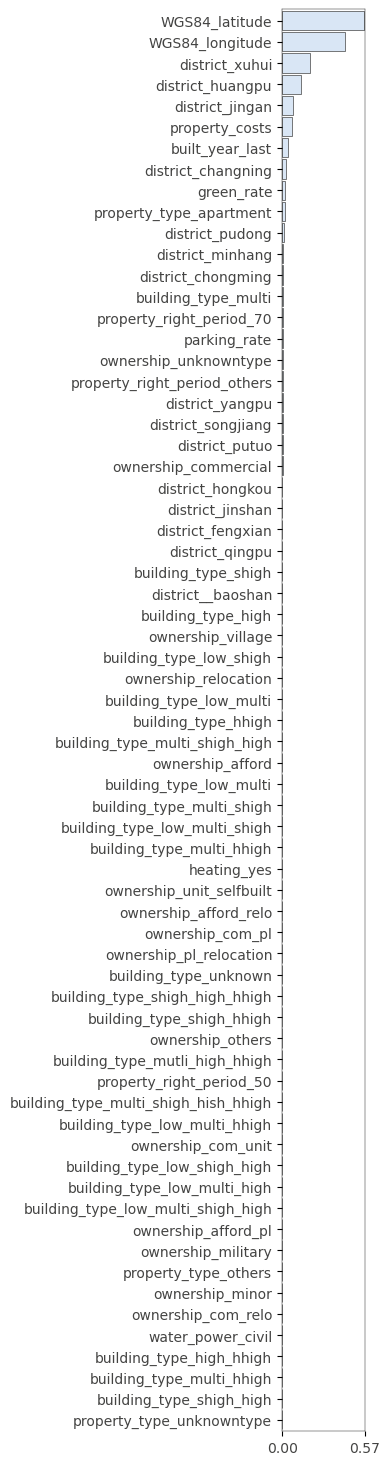

In [432]:
## predict the missing price data based on random forest
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
# # pip install rfpimp
# import rfpimp

# Split the data into training and testing sets (75:25 split)
X = price_subset.drop(['community_name', 'unit_price'], axis=1)
y = price_subset['unit_price']
random_state_split = 100
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = random_state_split)
print(X_train.index.identical(y_train.index))
print(X_test.index.identical(y_test.index))

# Perform cross-validation to find the best hyperparameters
hyperparameters = {
    'max_depth': [20,30,40],
    'min_samples_split': [2,4,6]
}
randomState_dt = 10000
rf = RandomForestRegressor(random_state = randomState_dt)
clf = GridSearchCV(rf, hyperparameters) # cv=5 by default, which means 5-fold cross-validation
clf.fit(X_train, y_train)

print ("The best parameter value is: ")
print (clf.best_params_)
print ("The best score is: ")
print (clf.best_score_)

# Train the Random Forest model using the best hyperparameters
rf_final = RandomForestRegressor(max_depth=clf.best_params_['max_depth'], min_samples_split=clf.best_params_['min_samples_split'], random_state=randomState_dt)
rf_final.fit(X_train, y_train)

# Evaluate the model's accuracy
print("R2 on the training data:")
print(rf_final.score(X=X_train, y=y_train))
print("R2 on the testing data:")
print(rf_final.score(X=X_test, y=y_test))
print("RMSE on the training data:")
print(mean_squared_error(y_train, rf_final.predict(X_train), squared=False))
print("RMSE on the testing data:")
print(mean_squared_error(y_test, rf_final.predict(X_test), squared=False))
# random forest get more accurate prediction

# # show the importance of each variablex
# imp = rfpimp.importances(rf_final, X_test, y_test)
# # print(imp)
# viz = rfpimp.plot_importances(imp)
# viz.view()

# predict the house price based on the built random forest model
missing_price_indices = non_price_subset.index
predicted_price = rf_final.predict(non_price_subset.drop(['unit_price','community_name'], axis=1))

# Update the missing values in the DataFrame
data_all_final['unit_price_rf'] = data_all_final['unit_price']
data_all_final.loc[missing_price_indices, 'unit_price_rf'] = predicted_price
data_all_final['unit_price_rf'] = data_all_final['unit_price_rf'].astype(float)

In [18]:
address = data_all_predict.loc[:,['community_name', 'address_1']]
address

data_all_final = pd.merge(data_all_final, address, on="community_name", how="left")
data_all_final.loc[:,['community_name','WGS84_longitude', 'WGS84_latitude','address_1']]

data_community_final = data_all_final.loc[:,['community_name', 'green_rate', 'property_costs', 'built_year_last',
       'WGS84_longitude', 'WGS84_latitude', 'unit_price','parking_rate', 'address_1']]
data_community_final.head()

data_community_final.to_csv("data_community_final.csv")

,community_name,address_1
0,阳光城愉景湾,上海市妙川路800弄
1,梅园三街坊,"上海市商城路1025弄,商城路991弄,乳山路130弄,乳山路138弄,乳山路160弄"
2,鼎鑫名流苑,上海市川周路8682弄
3,金桥爱建园,上海市碧云路199弄
4,中虹家园,上海市海鸣路98弄
...,...,...
20724,玉屏新村,上海市玉屏新村1-42号
20725,学宫新村,上海市学宫路581号
20726,新崇南路小区,上海市新崇南路35号
20727,风伟二村,上海市风伟二村1-7号
